In [1]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV, LinearRegression,
                                  MultiTaskElasticNet, MultiTaskElasticNetCV)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
ox.config(use_cache=True, log_console=False)

In [3]:
src = rasterio.open('LongNTL_2020.tif')

In [4]:
data = pd.read_csv("./LightPollution/Guangzhou_final.csv")
data = gpd.GeoDataFrame(
    data.loc[:, [c for c in data.columns if c != "geometry"]],
    geometry = gpd.GeoSeries.from_wkt(data["geometry"]),
    crs="EPSG:4326")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data

,ID,name,name:en,landuse,addr:province,addr:city,addr:district,description,type,total,...,grass_mean_NTL,industrial_mean_distance,industrial_mean_NTL,residential_mean_distance,residential_mean_NTL,retail_mean_distance,retail_mean_NTL,Over_illumination,centroid,geometry
0,0,胜坚尚城美居 大门,NaN,residential,广东省,江门市,蓬江区,NaN,NaN,45.0,...,29.404999,NaN,NaN,1380.711534,27.325571,NaN,NaN,1224.669991,POINT (113.0926213 22.607811),POINT (113.09262 22.60781)
1,1,春晖阁,NaN,residential,NaN,NaN,NaN,NaN,NaN,31.0,...,29.404999,NaN,NaN,2095.757109,26.265714,NaN,NaN,842.269988,POINT (113.06869572080743 22.58428373061638),"POLYGON ((113.06752 22.58401, 113.06799 22.583..."
2,2,山湖雅苑,NaN,residential,NaN,NaN,NaN,NaN,NaN,6.0,...,10.924999,NaN,NaN,1933.948178,20.246667,NaN,NaN,83.824999,POINT (113.04061246502903 22.586139690301295),"POLYGON ((113.03808 22.58640, 113.03719 22.585..."
3,3,阳光棕榈园,NaN,residential,NaN,NaN,NaN,NaN,NaN,102.0,...,NaN,2380.150312,15.564444,1413.460850,19.787627,1610.308933,26.287500,1900.035000,POINT (113.20270375876503 22.86718158011128),"POLYGON ((113.20167 22.86800, 113.20160 22.867..."
4,4,文华花园,NaN,residential,NaN,NaN,NaN,NaN,NaN,71.0,...,NaN,1990.241611,14.612500,1385.538034,15.721765,530.522314,21.744999,1084.569990,POINT (113.07640046752525 22.87221720573134),"POLYGON ((113.07858 22.87274, 113.07549 22.873..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4101,4101,星河丹堤花园,NaN,residential,NaN,NaN,NaN,NaN,multipolygon,104.0,...,27.486030,2046.743915,32.992500,2134.720596,39.951200,NaN,NaN,3772.600035,POINT (114.05329869300441 22.596217361214332),"POLYGON ((114.05129 22.59579, 114.05149 22.595..."
4102,4102,平山村,NaN,residential,NaN,NaN,NaN,NaN,multipolygon,89.0,...,20.230000,2511.075397,29.513333,1916.519761,31.831944,1040.984588,31.516668,2530.920017,POINT (113.96258481796976 22.587522741578148),"POLYGON ((113.96470 22.58744, 113.96472 22.586..."
4103,4103,溪头8区,Xitou Area 8,residential,NaN,NaN,NaN,NaN,multipolygon,17.0,...,NaN,NaN,NaN,2010.072860,38.020313,NaN,NaN,633.460004,POINT (113.82776705109957 22.774752934288582),"MULTIPOLYGON (((113.82699 22.77483, 113.82726 ..."
4104,4104,悠山美地家园,Youshanmeidi Jiayuan,residential,广东,深圳,龙华,NaN,multipolygon,140.0,...,37.186944,1409.939087,34.871786,1578.884291,36.834000,NaN,NaN,5018.054988,POINT (113.98934764961515 22.66781496726232),"POLYGON ((113.98911 22.66855, 113.98948 22.668..."


In [6]:
data = data.drop(data[data['Tresspass'] > 10].index)

In [7]:
features = ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL',
            'commercial', 'commercial_mean_distance', 'commercial_mean_NTL',
            'construction', 'construction_mean_distance', 'construction_mean_NTL',
            'farmland', 'farmland_mean_distance', 'farmland_mean_NTL',
            'forest', 'forest_mean_distance', 'forest_mean_NTL', 
            'grass',  'grass_mean_distance', 'grass_mean_NTL',
            'industrial', 'industrial_mean_distance', 'industrial_mean_NTL',
            'residential', 'residential_mean_distance', 'residential_mean_NTL', 
            'retail', 'retail_mean_distance', 'retail_mean_NTL']
len(features)

27

In [8]:
mean_val = data.mean()
data = data.fillna(mean_val)

In [9]:
data["Over_illumination"] = (data["Over illumination"] - data["Over illumination"].min()) / (data["Over illumination"].max() - data["Over illumination"].min())
data["Trespass"] = (data["Tresspass"] - data["Tresspass"].min()) / (data["Tresspass"].max() - data["Tresspass"].min())
data["Clutter"] = (data["Clutter"] - data["Clutter"].min()) / (data["Clutter"].max() - data["Clutter"].min())

In [12]:
data[["Over_illumination", "Trespass", "Clutter"]]

,Over_illumination,Trespass,Clutter
0,0.095106,0.095852,0.207051
1,0.065409,0.042798,0.181173
2,0.006510,0.003190,0.110913
3,0.147553,0.141414,0.181557
4,0.084226,0.098154,0.183914
...,...,...,...
4101,0.292973,0.229253,0.309060
4102,0.196547,0.194702,0.259727
4103,0.049193,0.034941,0.416022
4104,0.389693,0.469731,0.351881


In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['residential', 'residential_mean_distance', 'residential_mean_NTL']]].values)
T = scaler.fit_transform(data[['residential', 'residential_mean_distance', 'residential_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary.reset_index(inplace=True)

Summary["Treatment"] = "residential"

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.518,0.017,30.521,0.0,0.490,0.546,residential
1,0,Y1,0.414,0.017,24.973,0.0,0.387,0.442,residential
2,0,Y2,0.390,0.019,20.043,0.0,0.358,0.422,residential


In [15]:
residential_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
residential_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
residential_effect = pd.melt(residential_effect, id_vars=["Treatment"], var_name = "Outcome")
residential_effect

sns.set_style("")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = residential_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Residential")
plt.savefig("residential2.svg", bbox_inches = "tight")

ValueError: style must be one of white, dark, whitegrid, darkgrid, ticks

In [16]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']]].values)
T = scaler.fit_transform(data[['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary.reset_index(inplace=True)

summary["Treatment"] = "commercial"
Summary = pd.concat([Summary, summary], axis = 0)

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.518,0.017,30.521,0.000,0.490,0.546,residential
1,0,Y1,0.414,0.017,24.973,0.000,0.387,0.442,residential
2,0,Y2,0.390,0.019,20.043,0.000,0.358,0.422,residential
0,0,Y0,0.421,0.029,14.734,0.000,0.374,0.468,commercial
1,0,Y1,0.265,0.028,9.622,0.000,0.220,0.310,commercial
2,0,Y2,0.102,0.036,2.858,0.004,0.043,0.161,commercial


In [17]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['retail', 'retail_mean_distance', 'retail_mean_NTL']]].values)
T = scaler.fit_transform(data[['retail', 'retail_mean_distance', 'retail_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "retail"
Summary = pd.concat([Summary, summary], axis = 0)
Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.518,0.017,30.521,0.000,0.490,0.546,residential
1,0,Y1,0.414,0.017,24.973,0.000,0.387,0.442,residential
2,0,Y2,0.390,0.019,20.043,0.000,0.358,0.422,residential
0,0,Y0,0.421,0.029,14.734,0.000,0.374,0.468,commercial
1,0,Y1,0.265,0.028,9.622,0.000,0.220,0.310,commercial
2,0,Y2,0.102,0.036,2.858,0.004,0.043,0.161,commercial
0,0,Y0,0.130,0.017,7.680,0.000,0.102,0.158,retail
1,0,Y1,0.055,0.016,3.472,0.001,0.029,0.080,retail
2,0,Y2,-0.039,0.016,-2.517,0.012,-0.065,-0.014,retail


In [18]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']]].values)
T = scaler.fit_transform(data[['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary2 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary2.reset_index(inplace=True)

Summary2["Treatment"] = "brownfield"
# Summary = pd.concat([Summary, summary], axis = 0)

Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.225,0.019,11.789,0.000,0.193,0.256,brownfield
1,0,Y1,0.211,0.018,11.915,0.000,0.182,0.240,brownfield
2,0,Y2,0.047,0.016,2.936,0.003,0.020,0.073,brownfield


In [19]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['construction', 'construction_mean_distance', 'construction_mean_NTL',]]].values)
T = scaler.fit_transform(data[['construction', 'construction_mean_distance', 'construction_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "construction"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.225,0.019,11.789,0.000,0.193,0.256,brownfield
1,0,Y1,0.211,0.018,11.915,0.000,0.182,0.240,brownfield
2,0,Y2,0.047,0.016,2.936,0.003,0.020,0.073,brownfield
0,0,Y0,0.332,0.026,13.007,0.000,0.290,0.374,construction
1,0,Y1,0.170,0.025,6.834,0.000,0.129,0.211,construction
2,0,Y2,-0.095,0.024,-3.917,0.000,-0.136,-0.055,construction


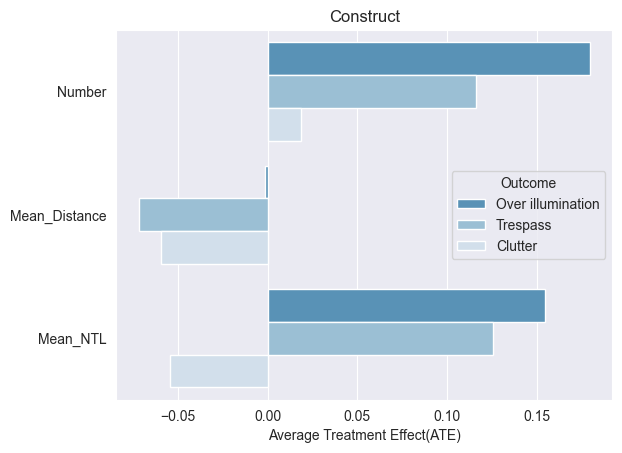

In [20]:
construct_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
construct_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
construct_effect = pd.melt(construct_effect, id_vars=["Treatment"], var_name = "Outcome")
construct_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = construct_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Construct")
plt.savefig("construct2.svg", bbox_inches = "tight")

In [21]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['industrial', 'industrial_mean_distance', 'industrial_mean_NTL']]].values)
T = scaler.fit_transform(data[['industrial', 'industrial_mean_distance', 'industrial_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True
                )

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "industrial"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.225,0.019,11.789,0.000,0.193,0.256,brownfield
1,0,Y1,0.211,0.018,11.915,0.000,0.182,0.240,brownfield
2,0,Y2,0.047,0.016,2.936,0.003,0.020,0.073,brownfield
0,0,Y0,0.332,0.026,13.007,0.000,0.290,0.374,construction
1,0,Y1,0.170,0.025,6.834,0.000,0.129,0.211,construction
2,0,Y2,-0.095,0.024,-3.917,0.000,-0.136,-0.055,construction
0,0,Y0,0.135,0.027,4.947,0.000,0.090,0.180,industrial
1,0,Y1,0.114,0.025,4.499,0.000,0.072,0.156,industrial
2,0,Y2,0.040,0.027,1.455,0.146,-0.005,0.084,industrial


In [22]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['grass', 'grass_mean_distance', 'grass_mean_NTL']]].values)
T = scaler.fit_transform(data[['grass', 'grass_mean_distance', 'grass_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary3 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary3.reset_index(inplace=True)

Summary3["Treatment"] = "grass"
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.638,0.050,12.823,0.0,0.556,0.720,grass
1,0,Y1,0.458,0.049,9.341,0.0,0.378,0.539,grass
2,0,Y2,-0.159,0.032,-5.037,0.0,-0.211,-0.107,grass


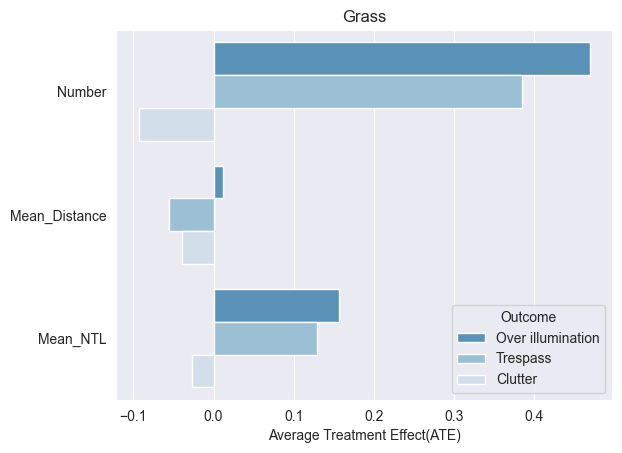

In [23]:
grass_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
grass_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
grass_effect = pd.melt(grass_effect, id_vars=["Treatment"], var_name = "Outcome")
grass_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = grass_effect,
    y = "Treatment", x = "value", hue = "Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title = "Grass")
plt.savefig("grass2.svg", bbox_inches = "tight")

In [24]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['farmland', 'farmland_mean_distance', 'farmland_mean_NTL']]].values)
T = scaler.fit_transform(data[['farmland', 'farmland_mean_distance', 'farmland_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "farmland"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.638,0.050,12.823,0.000,0.556,0.720,grass
1,0,Y1,0.458,0.049,9.341,0.000,0.378,0.539,grass
2,0,Y2,-0.159,0.032,-5.037,0.000,-0.211,-0.107,grass
0,0,Y0,0.045,0.023,1.908,0.056,0.006,0.083,farmland
1,0,Y1,0.038,0.023,1.683,0.092,0.001,0.076,farmland
2,0,Y2,0.068,0.021,3.179,0.001,0.033,0.102,farmland


In [25]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['forest', 'forest_mean_distance', 'forest_mean_NTL']]].values)
T = scaler.fit_transform(data[['forest', 'forest_mean_distance', 'forest_mean_NTL', ]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "forest"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.638,0.050,12.823,0.000,0.556,0.720,grass
1,0,Y1,0.458,0.049,9.341,0.000,0.378,0.539,grass
2,0,Y2,-0.159,0.032,-5.037,0.000,-0.211,-0.107,grass
0,0,Y0,0.045,0.023,1.908,0.056,0.006,0.083,farmland
1,0,Y1,0.038,0.023,1.683,0.092,0.001,0.076,farmland
2,0,Y2,0.068,0.021,3.179,0.001,0.033,0.102,farmland
0,0,Y0,0.182,0.028,6.520,0.000,0.136,0.228,forest
1,0,Y1,0.077,0.026,2.938,0.003,0.034,0.121,forest
2,0,Y2,0.036,0.025,1.452,0.147,-0.005,0.076,forest


In [26]:
x = Summary["Treatment"]
y = Summary["point_estimate"]
yerr = Summary["stderr"]

In [27]:
Summary.loc[Summary["Y"]=="Y0", "Y"] = "Over Illumination"
Summary.loc[Summary["Y"]=="Y1", "Y"] = "Trespass"
Summary.loc[Summary["Y"]=="Y2", "Y"] = "Clutter"

Summary.rename(columns={"Y": "Outcome"}, inplace = True)

In [28]:
Summary2.loc[Summary2["Y"]=="Y0", "Y"] = "Over Illumination"
Summary2.loc[Summary2["Y"]=="Y1", "Y"] = "Trespass"
Summary2.loc[Summary2["Y"]=="Y2", "Y"] = "Clutter"

Summary2.rename(columns={"Y": "Outcome"}, inplace = True)

In [29]:
Summary3.loc[Summary3["Y"]=="Y0", "Y"] = "Over Illumination"
Summary3.loc[Summary3["Y"]=="Y1", "Y"] = "Trespass"
Summary3.loc[Summary3["Y"]=="Y2", "Y"] = "Clutter"

Summary3.rename(columns = {"Y": "Outcome"}, inplace = True)

In [30]:
Summarys = [Summary, Summary2, Summary3]

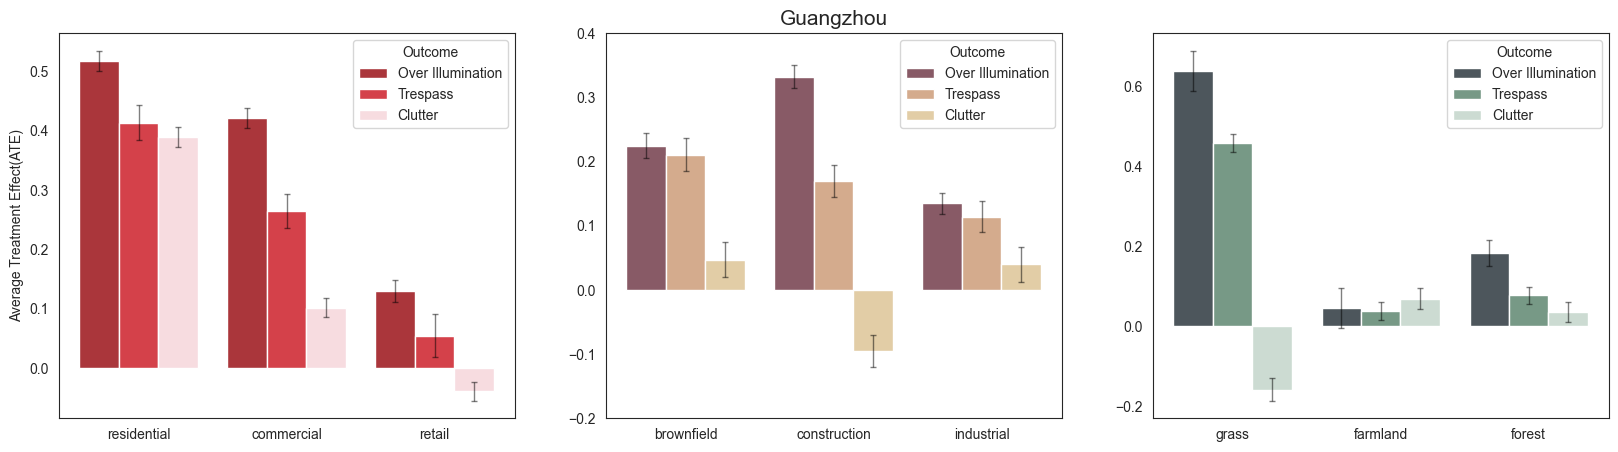

In [34]:
import pandas as pd
import seaborn as sns


# plt.figure(figsize = (20, 5))
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

flatui = ["#BD2329", "#EC2835", "#FCD7DD"]
sns.set_palette(flatui)

sns.barplot(
    data = Summary,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[0]
)

flatui = ["#8f5362", "#e0a981", "#ecd09c"]
sns.set_palette(flatui)

axes[1] = sns.barplot(
    data = Summary2,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[1]
)

# flatui = ["#79b4a0", "#a3c8a4", "#d4daa1"]
# sns.set_palette(flatui)

flatui = ["#4A565F", "#719F85", "#CADDD1"]
sns.set_palette(flatui)

axes[2] = sns.barplot(
    data = Summary3,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[2]
)

for index in range(3):
    x = Summarys[index]["Treatment"]
    y = Summarys[index]["point_estimate"]
    yerr = Summarys[index]["stderr"]
    
    bars = [c for c in axes[index].get_children() if isinstance(c, matplotlib.patches.Rectangle)]
    bars = bars[:-1]
    
    for i, bar in enumerate(bars):
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width() / 2
            axes[index].errorbar(x = x_pos, y = height, yerr = yerr.iloc[i], fmt = 'none', capsize = 2, color = 'black', elinewidth = 1, alpha = 0.5)

# plt.savefig("ATE2.svg", bbox_inches = "tight")
axes[1].set_title("Guangzhou", fontsize = 15)
axes[1].set_ylim([-0.2, 0.4])
axes[0].set(xlabel = '', ylabel = "Average Treatment Effect(ATE)")
# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)
axes[1].set(xlabel = '', ylabel = "")
axes[2].set(xlabel = '', ylabel = "")

plt.savefig("ATE_GZ.svg", bbox_inches = "tight")